In [13]:
#!pip install nltk
import nltk
#nltk.download("reuters")

import pandas as pd
from nltk.corpus import reuters
import numpy as np
import matplotlib.pyplot as plt 

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import GaussianNB

## checking dataset

In [14]:
reuters.categories("training/9865")

['barley', 'corn', 'grain', 'wheat']

In [15]:
reuters.fileids("barley")[50]

'training/9958'

In [16]:
reuters.raw("training/9865")

"FRENCH FREE MARKET CEREAL EXPORT BIDS DETAILED\n  French operators have requested licences\n  to export 675,500 tonnes of maize, 245,000 tonnes of barley,\n  22,000 tonnes of soft bread wheat and 20,000 tonnes of feed\n  wheat at today's European Community tender, traders said.\n      Rebates requested ranged from 127.75 to 132.50 European\n  Currency Units a tonne for maize, 136.00 to 141.00 Ecus a tonne\n  for barley and 134.25 to 141.81 Ecus for bread wheat, while\n  rebates requested for feed wheat were 137.65 Ecus, they said.\n  \n\n"

# 1.	Use appropriate NLTK coding to visualize the number of documents per category in the training set. Is the dataset class balanced? Motivate your answer.

Go through categories and get number of documents in each. Then put them in dataframe.

In [86]:
frame = {"category":[], "Num_docs":[]}          # initialize frame with empty lists
for i in reuters.categories():                  # iterate through categories
    documents_num = len(reuters.fileids(i))         # get number of documents/category

    #print(f"{i} has {documents} documents")
    frame["category"].append(i)                 # Append category name and
    frame["Num_docs"].append(documents_num)         # number of documents on approppriate column

data=pd.DataFrame(data=frame)                   # make dataframe fr
#data["category_id"] = data["category"].factorize()[0] 
data # check data


,category,Num_docs
0,acq,2369
1,alum,58
2,barley,51
3,bop,105
4,carcass,68
...,...,...
85,veg-oil,124
86,wheat,283
87,wpi,29
88,yen,59


Plot bar graph with matplotlib and annotate categories that have more than 400 documents (name only these to keep plot readable)

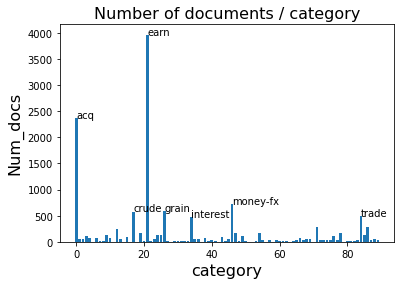

In [18]:
# make new dataframe from rows which num_docs >= 400 to annotate
df = data.query('Num_docs >= 400')

# bar plot with matplotlib in Python
plt.bar(data.index, data.Num_docs, alpha=1)   

# iterate through index
for i in df.index:                                      
    plt.annotate(data.iloc[i,0], (i,data.iloc[i,1]))    # add categories names to datapoints which are >= 400

# set x-axis label and specific size
plt.xlabel('category',size=16)                          
# set y-axis label and specific size
plt.ylabel('Num_docs',size=16)
# set plot title with specific size
plt.title('Number of documents / category',size=16)
# save the plot as PNG file with dpi=150
#plt.savefig('docs_per_category.png', dpi=150)
plt.show()

# 2. Construct the feature set using CountVectorizer of the training dataset so that the maximum size of the feature set is 100 and each word feature should be contained in at least 3 documents and in less than 70% of total documents to be considered. Use standard preprocessing and stopword list, with WordNet lemmatizer.

In [19]:
# use wordnetlemmatizer 

def preProcess(doc):
    WN_lemmatizer = WordNetLemmatizer()

    sentences = sent_tokenize(doc)
    Tokens = []
    for sentence in sentences:
        words = word_tokenize(sentence)
        words = [WN_lemmatizer.lemmatize(word, pos="v") for word in words]
        Tokens.extend(words)
        
    return ' '.join(Tokens)

In [21]:
# define countVectrizer and fit

def BOW_model(corpus):
    BOW = CountVectorizer(preprocessor=preProcess,max_features = 100, stop_words = "english", min_df = 3, max_df = 0.7)
    #BOW.fit(corpus)
    #X = BOW.transform(corpus)
    X = BOW.fit_transform(corpus)
    
    #print(BOW.get_feature_names())
    return X

## Extract data from reuters Dataset and divide to Training and Test variables

In [22]:
# select fileid
doc_list = np.array(reuters.fileids())
#doc_list = doc_list[doc_list != 'training/3267']

# create test and train IDs from documents
test_doc = doc_list[['test' in x for x in doc_list]]

train_doc = doc_list[['training' in x for x in doc_list]]

# create test and train corpuses using IDs
test_corpus = [" ".join([t for t in reuters.words(test_doc[t])]) for t in range(len(test_doc))]
train_corpus = [" ".join([t for t in reuters.words(train_doc[t])]) for t in range(len(train_doc))]



## Get labels ( categories? ) for each document
How? there is multiple categories for part of the documents.

In [195]:

def create_df(data):
    """Create DataFrames to visualise data a bit and duplicate multi-categorial documents so that they have just one category but appear multiple times.
    - data: list of documents (e.g. train and test data)"""
    docs=[]
    for ids in data:
        cats = reuters.categories(ids) # At each iteration we retrieve categories of an id
        doc = " ".join(reuters.words(ids))  # join words from each document
        for cat in cats:
            docs.append((doc, cat, ids)) # These documents are appended as a tuple (document, category, ids) in the list

    df=pd.DataFrame(docs, columns=['document', 'category','ids']) #The data frame is created using the generated tuple.

    #df # check dataframe
    return df

# train_df["ids"].duplicated().value_counts() # checks how many duplicates because of categories


In [198]:
create_df(train_doc)

,document,category,ids
0,BAHIA COCOA REVIEW Showers continued throughou...,cocoa,training/1
1,COMPUTER TERMINAL SYSTEMS & lt ; CPML > COMPLE...,acq,training/10
2,N . Z . TRADING BANK DEPOSIT GROWTH RISES SLIG...,money-supply,training/100
3,NATIONAL AMUSEMENTS AGAIN UPS VIACOM & lt ; VI...,acq,training/1000
4,ROGERS & lt ; ROG > SEES 1ST QTR NET UP SIGNIF...,earn,training/10000
...,...,...,...
9579,U . K . MONEY MARKET SHORTAGE FORECAST REVISED...,money-fx,training/999
9580,KNIGHT - RIDDER INC & lt ; KRN > SETS QUARTERL...,earn,training/9992
9581,TECHNITROL INC & lt ; TNL > SETS QUARTERLY Qtl...,earn,training/9993
9582,NATIONWIDE CELLULAR SERVICE INC & lt ; NCEL > ...,earn,training/9994


In [193]:
create_df(test_doc)

,document,category,ids
0,ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPA...,trade,test/14826
1,CHINA DAILY SAYS VERMIN EAT 7 - 12 PCT GRAIN S...,grain,test/14828
2,JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWN...,crude,test/14829
3,JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWN...,nat-gas,test/14829
4,THAI TRADE DEFICIT WIDENS IN FIRST QUARTER Tha...,corn,test/14832
...,...,...,...
3739,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...,money-fx,test/21573
3740,TOKYO DEALERS SEE DOLLAR POISED TO BREACH 140 ...,yen,test/21573
3741,JAPAN / INDIA CONFERENCE CUTS GULF WAR RISK CH...,ship,test/21574
3742,SOVIET INDUSTRIAL GROWTH / TRADE SLOWER IN 198...,ipi,test/21575


In [23]:
len(train_corpus)

7769

## Get Feature vectors from documents

In [24]:
BOW = BOW_model(train_corpus)

C:\Users\Joonas\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


['000', '10', '11', '12', '15', '16', '1985', '1986', '1987', '20', '25', '30', '31', '50', 'April', 'Bank', 'But', 'Co', 'Corp', 'February', 'He', 'IN', 'INC', 'In', 'Inc', 'It', 'January', 'Japan', 'Ltd', 'March', 'NET', 'Net', 'Oper', 'QTR', 'Revs', 'Shr', 'TO', 'The', 'add', 'agreement', 'bank', 'billion', 'buy', 'company', 'cts', 'current', 'dlr', 'dlrs', 'dollar', 'earn', 'end', 'exchange', 'expect', 'export', 'foreign', 'gain', 'government', 'group', 'hold', 'import', 'include', 'increase', 'loss', 'lt', 'make', 'market', 'meet', 'mln', 'month', 'net', 'new', 'offer', 'oil', 'pct', 'plan', 'price', 'production', 'profit', 'quarter', 'rat', 'rate', 'report', 'result', 'rise', 'sales', 'say', 'sell', 'share', 'stg', 'stock', 'tax', 'tell', 'term', 'today', 'tonnes', 'total', 'trade', 'vs', 'week', 'year']


In [91]:
features_train = BOW.toarray()
print(features_train)


[[0 0 0 ... 0 2 2]
 [3 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 3]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 8 0 0]
 [2 0 0 ... 4 0 0]]


# 3. Use NaivesBayes classifier to generate the model and test it on the testing dataset. Output the accuracy and F1 measure of this classifier. Compare the result with Random Forest and linear SVM classifiers.


In [35]:
# Create a Gaussian Classifier
gnb = GaussianNB()

In [93]:
#gnb.fit(features, test_corpus)
classifier = nltk.NaiveBayesClassifier.train(, features_train)
#?nltk.NaiveBayesClassifier

TypeError: 'method' object is not iterable

In [94]:
reuters.categories()

['acq',
 'alum',
 'barley',
 'bop',
 'carcass',
 'castor-oil',
 'cocoa',
 'coconut',
 'coconut-oil',
 'coffee',
 'copper',
 'copra-cake',
 'corn',
 'cotton',
 'cotton-oil',
 'cpi',
 'cpu',
 'crude',
 'dfl',
 'dlr',
 'dmk',
 'earn',
 'fuel',
 'gas',
 'gnp',
 'gold',
 'grain',
 'groundnut',
 'groundnut-oil',
 'heat',
 'hog',
 'housing',
 'income',
 'instal-debt',
 'interest',
 'ipi',
 'iron-steel',
 'jet',
 'jobs',
 'l-cattle',
 'lead',
 'lei',
 'lin-oil',
 'livestock',
 'lumber',
 'meal-feed',
 'money-fx',
 'money-supply',
 'naphtha',
 'nat-gas',
 'nickel',
 'nkr',
 'nzdlr',
 'oat',
 'oilseed',
 'orange',
 'palladium',
 'palm-oil',
 'palmkernel',
 'pet-chem',
 'platinum',
 'potato',
 'propane',
 'rand',
 'rape-oil',
 'rapeseed',
 'reserves',
 'retail',
 'rice',
 'rubber',
 'rye',
 'ship',
 'silver',
 'sorghum',
 'soy-meal',
 'soy-oil',
 'soybean',
 'strategic-metal',
 'sugar',
 'sun-meal',
 'sun-oil',
 'sunseed',
 'tea',
 'tin',
 'trade',
 'veg-oil',
 'wheat',
 'wpi',
 'yen',
 'zinc']

# 4. Show the results of this classifier when the total number of features varies as 1000, 1500, 2000, 2500, 3000, 3500, 4500, 5000.

# 5. Repeat 3) when a PCA (of 95% information preservation) is used to reduce the dimension of the feature space. 


# 6. Instead of CountVectorizer, use TfidfVectorizer to create the feature set as in 2) and test the classification accuracy and F1 measure of Naives’ Bayes classifier.


# 7. Use Word2vec to create a feature vector to each document by averaging over all word2vec representations of individual words constituting the document. Use this feature set to train the Naives’ Bayes classifier and output the accuracy, F1 measure and confusion matrix on testing data. 


# 8. Now we would like to tackle the discrepancy of the number of instances in training data among the various categories. For this purpose, create a new partition, where you remove the categories that contains very large number of instances and very low number of instances as compared to the rest of the categories. Repeat 3) and provide the results on the table. 

# 9. Similarly, use word2vec model to calculate the new performance on the testing data for the new set of categories in 8).

# 10. Now we would like to handle the data discrepancy in the class, we would like to perform data augmentation on the small size classes. For this purpose, for the classes, which contain small number of instances, write a script that allows you to duplicate the number of small samples at an order close to the average of other classes. Then repeat the process 3) and test whether an enhancement of the results on the testing data can be noticed.
 

# 11. Now we would like to test the influence of the multi-category documents on the classification. For this purpose, write a script, which scrutinizes the training set, so that every document, which is found to belong to more than one category in the training set is removed. Repeat 3) and word2vec model to evaluate the performance of the model on the test data, and discuss the contribution of this removal action. 

# 12. Use appropriate literature in order to comment on your findings. 